## Import TensorFlow and other libraries

In [1]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display
from glob import glob
import numpy as np

from datetime import datetime

In [2]:
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


## Load the dataset

You can download this dataset and similar datasets from [here](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets). As mentioned in the [paper](https://arxiv.org/abs/1611.07004), apply random jittering and mirroring to the training dataset.

* In random jittering, the image is resized to `286 x 286` and then randomly cropped to `256 x 256`
* In random mirroring, the image is randomly flipped horizontally i.e left to right.

In [3]:
path_train = "/glade/scratch/hgamarro/Deep_learning/Final_Project/data/interim/Vegas_v1/train/"
path_val = "/glade/scratch/hgamarro/Deep_learning/Final_Project/data/interim/Vegas_v1/train/"

In [4]:
BUFFER_SIZE = 400
BATCH_SIZE = 32
IMG_WIDTH = 512
IMG_HEIGHT = 512

In [5]:
def load_data(path):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "masks/*")))

    return images, masks


def load_image_mask(image_file,mask_file):
    input_image = tf.io.read_file(image_file)
    input_image = tf.image.decode_png(input_image)
    
    mask_image = tf.io.read_file(mask_file)
    mask_image = tf.image.decode_png(mask_image)


    input_image = tf.cast(input_image, tf.float32)
    mask_image = tf.cast(mask_image, tf.float32)

    return input_image, mask_image

def resize(input_image, mask_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask_image = tf.image.resize(mask_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, mask_image

def normalize(input_image, mask_image):
    input_image = (input_image / 255)
    mask_image = (mask_image / 1) 

    return input_image, mask_image



In [6]:
def load_image_train(image_file,mask_file):
    input_image, mask_image = load_image_mask(image_file,mask_file)
    input_image, mask_image = resize(input_image, mask_image,
                                   IMG_WIDTH, IMG_HEIGHT)
    input_image, mask_image = normalize(input_image, mask_image)
    return input_image, mask_image

In [7]:
def load_image_test(image_file,mask_file):
    input_image, mask_image = load_image_mask(image_file,mask_file)
    input_image, mask_image = resize(input_image, mask_image,
                                   IMG_WIDTH, IMG_HEIGHT)
    input_image, mask_image = normalize(input_image, mask_image)
    return input_image, mask_image

## Input Pipeline

In [8]:
train_images_list, train_masks_list = load_data(path_train)
print(f"Images: {len(train_images_list)} - Masks: {len(train_masks_list)}")

train_dataset = tf.data.Dataset.from_tensor_slices((train_images_list, train_masks_list))
train_dataset = train_dataset.map(load_image_test,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

Images: 2303 - Masks: 2303


In [9]:
val_images_list, val_masks_list = load_data(path_train)
print(f"Images: {len(val_images_list)} - Masks: {len(val_masks_list)}")

test_dataset = tf.data.Dataset.from_tensor_slices((val_images_list, val_masks_list))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

Images: 2303 - Masks: 2303


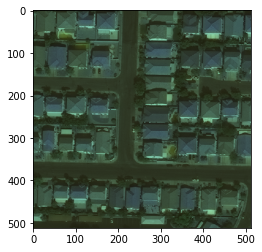

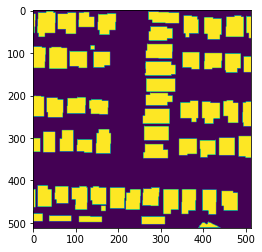

In [10]:
inp, re = load_image_train(train_images_list[100], train_masks_list[100])
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp)
plt.figure()
plt.imshow(re)

## Build the Generator
  * The architecture of generator is a modified U-Net.
  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).


In [11]:
OUTPUT_CHANNELS = 1

In [12]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

        result.add(tf.keras.layers.LeakyReLU())

    return result

In [13]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 256, 256, 3)


In [14]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [15]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 512, 512, 3)


In [16]:
import segmentation_models as sm
sm.set_framework('tf.keras')

BACKBONE = 'vgg16'
# BACKBONE = 'resnet50'
# BACKBONE = 'efficientnetb6'
model_name = 'Unet'
BATCH_SIZE = 32
LR = 0.0001
EPOCHS = 100

n_classes = 1  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model

generator = sm.Unet(BACKBONE,classes=n_classes,input_shape=(512, 512, 3), activation=activation)

Segmentation Models: using `tf.keras` framework.


In [17]:
# def Generator():
#     inputs = tf.keras.layers.Input(shape=[512, 512, 3])

#     down_stack = [
#         downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
#         downsample(128, 4),  # (bs, 64, 64, 128)
#         downsample(256, 4),  # (bs, 32, 32, 256)
#         downsample(512, 4),  # (bs, 16, 16, 512)
#         downsample(512, 4),  # (bs, 8, 8, 512)
#         #downsample(64, 4),  # (bs, 4, 4, 512)
#         downsample(512, 4),  # (bs, 2, 2, 512)
#         downsample(512, 4),  # (bs, 1, 1, 512)
#     ]

#     up_stack = [
#         upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
#         upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
#         #upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
#         upsample(512, 4, apply_dropout=True),  # (bs, 16, 16, 1024)
#         upsample(256, 4),  # (bs, 32, 32, 512)
#         upsample(128, 4),  # (bs, 64, 64, 256)
#         upsample(64, 4),  # (bs, 128, 128, 128)
#     ]

#     initializer = tf.random_normal_initializer(0., 0.02)
#     last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
#                                          strides=2,
#                                          padding='same',
#                                          kernel_initializer=initializer,
#                                          activation='tanh')  # (bs, 256, 256, 3)

#     x = inputs

#     # Downsampling through the model
#     skips = []
#     for down in down_stack:
#         x = down(x)
#         skips.append(x)

#     skips = reversed(skips[:-1])

#   # Upsampling and establishing the skip connections
#     for up, skip in zip(up_stack, skips):
#         x = up(x)
#         x = tf.keras.layers.Concatenate()([x, skip])

#     x = last(x)

#     with mirrored_strategy.scope():
#         return tf.keras.Model(inputs=inputs, outputs=x)

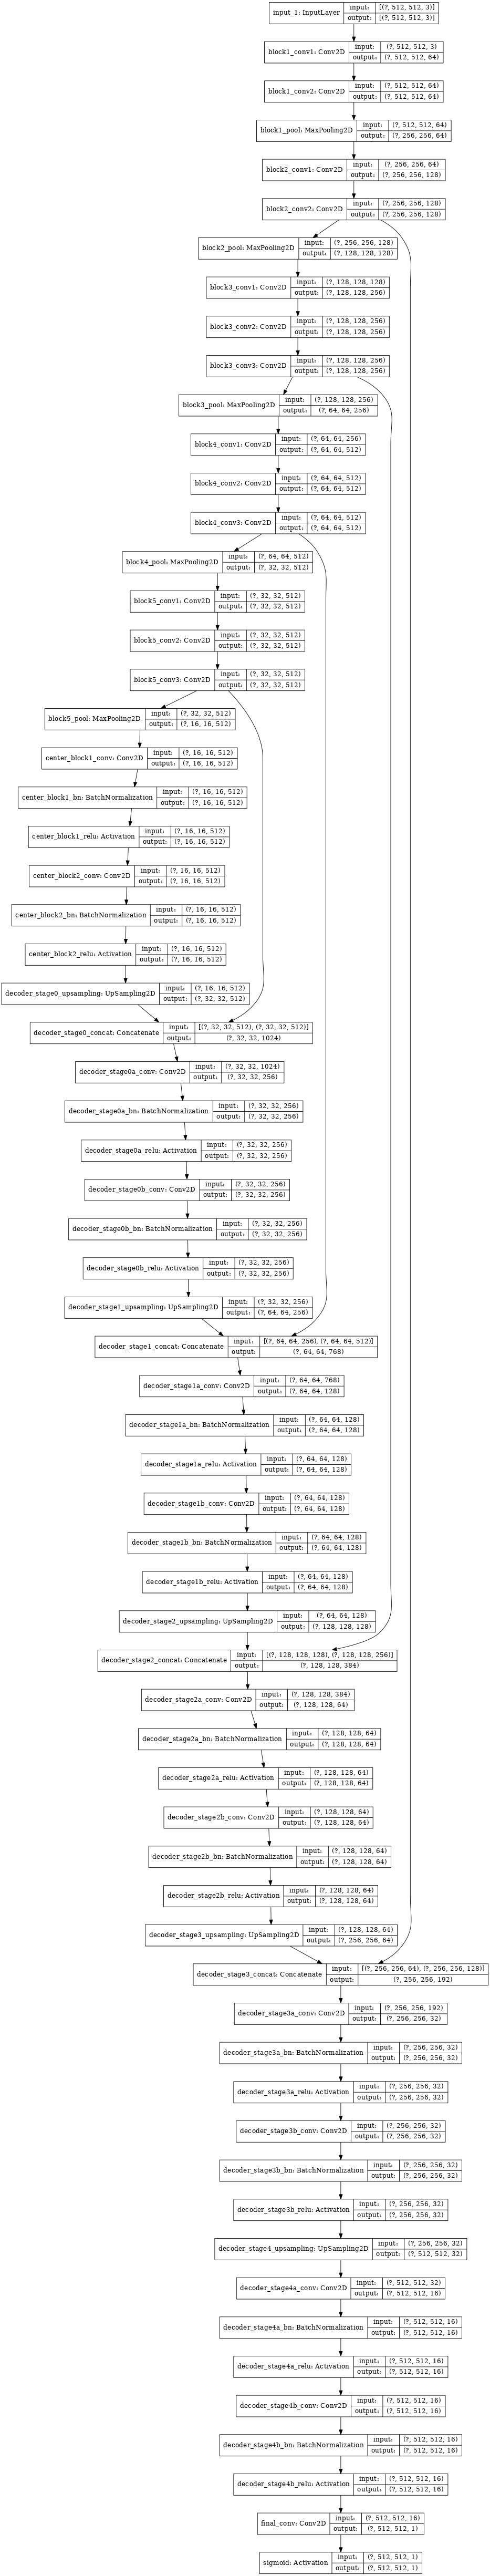

In [17]:
# generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

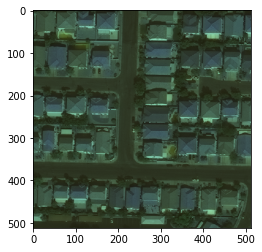

In [18]:
plt.imshow(inp)

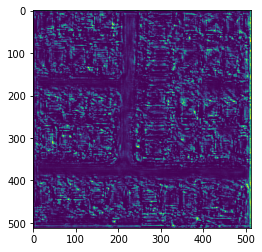

In [19]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [20]:
np.histogram((gen_output))

(array([196036,  25022,  12306,   7589,   5414,   4211,   3386,   2962,
          2586,   2632]),
 array([1.00017994e-10, 9.99995843e-02, 1.99999169e-01, 2.99998760e-01,
        3.99998337e-01, 4.99997914e-01, 5.99997520e-01, 6.99997067e-01,
        7.99996674e-01, 8.99996221e-01, 9.99995828e-01], dtype=float32))

* **Generator loss**
  * It is a sigmoid cross entropy loss of the generated images and an **array of ones**.
  * The [paper](https://arxiv.org/abs/1611.07004) also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
  * This allows the generated image to become structurally similar to the target image.
  * The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the [paper](https://arxiv.org/abs/1611.07004).

The training procedure for the generator is shown below:

In [21]:
LAMBDA = 100

In [22]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [23]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## Build the Discriminator
  * The Discriminator is a PatchGAN.
  * Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
  * The shape of the output after the last layer is (batch_size, 30, 30, 1)
  * Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
  * Discriminator receives 2 inputs.
    * Input image and the target image, which it should classify as real.
    * Input image and the generated image (output of generator), which it should classify as fake.
    * Concatenate these 2 inputs together in the code (`tf.concat([inp, tar], axis=-1)`)

In [24]:
# def Discriminator():
#     initializer = tf.random_normal_initializer(0., 0.02)

#     inp = tf.keras.layers.Input(shape=(512, 512, 3), name='input_image')
#     tar = tf.keras.layers.Input(shape=(512, 512, 1), name='target_image')

#     x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

#     down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
#     down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
#     down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)
#     down4 = downsample(512, 4)(down3)  # (bs, 32, 32, 256)

#     zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4)  # (bs, 34, 34, 256)
#     conv = tf.keras.layers.Conv2D(512*2, 4, strides=1,
#                                 kernel_initializer=initializer,
#                                 use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

#     batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

#     leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

#     zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

#     last = tf.keras.layers.Conv2D(1, 4, strides=1,
#                                 kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

# #     with mirrored_strategy.scope():
#     return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [25]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=(512, 512, 3), name='input_image')
    tar = tf.keras.layers.Input(shape=(512, 512, 1), name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)
    down4 = downsample(512, 4)(down2)  # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

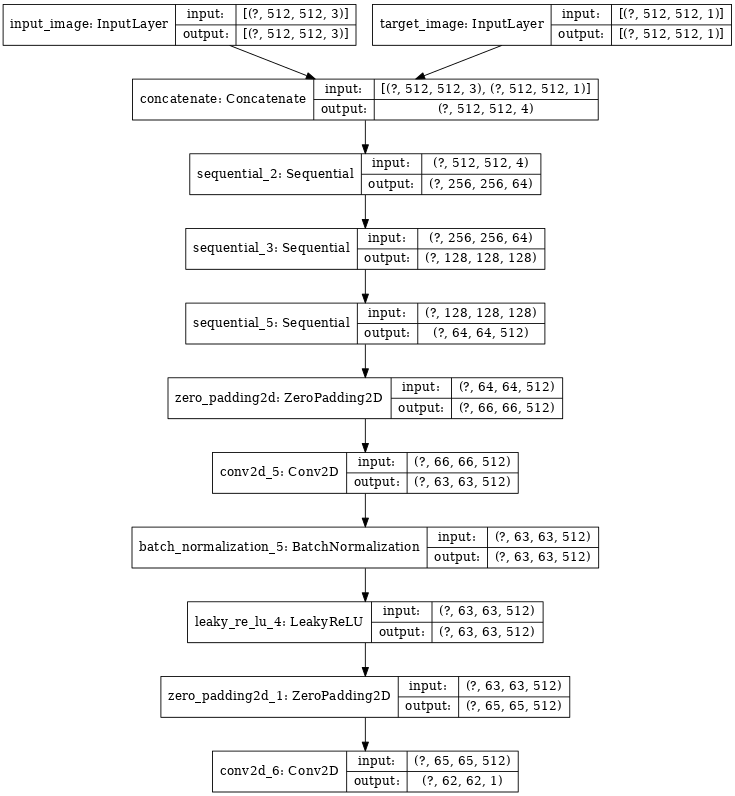

In [26]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

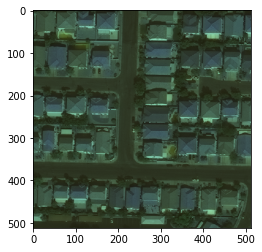

In [27]:
plt.imshow(inp)

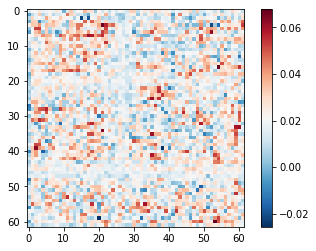

In [28]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], cmap='RdBu_r')
plt.colorbar()

**Discriminator loss**
  * The discriminator loss function takes 2 inputs; **real images, generated images**
  * real_loss is a sigmoid cross entropy loss of the **real images** and an **array of ones(since these are the real images)**
  * generated_loss is a sigmoid cross entropy loss of the **generated images** and an **array of zeros(since these are the fake images)**
  * Then the total_loss is the sum of real_loss and the generated_loss


In [29]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer the [paper](https://arxiv.org/abs/1611.07004).

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## Define the Optimizers and Checkpoint-saver


In [30]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Validate Images

In [31]:
def IOUscore(tar ,pred):
    
    bool_tar = np.array(tar ,dtype=bool)
    bool_pred = np.array(tf.math.greater(pred ,.5))
    #bool_pred = np.array(tf.math.greater(pred ,.5))
    
    intersection = bool_tar * bool_pred
    union = bool_tar + bool_pred
    return intersection.sum() / union.sum()

In [32]:
def val_images(model, test_input, tar):
    prediction = model(test_input, training=False)
#     iou_score = IOUscore(tar ,prediction)
    
    iou_score = metrics[0](prediction, tar)
    f1_score = metrics[1](prediction, tar)
    
    return iou_score, f1_score

In [33]:
# start = datetime.now()

# sum_iou = []
# for example_input, example_target in test_dataset.take(10):
#     prediction = generator(example_input, training=False )
    
#     metrics.update_state(example_target,prediction , sample_weight=None)
#     sum_iou.append(metrics.result().numpy())
#     metrics.reset_states()
    
# iou_average = np.average(sum_iou)

# end = datetime.now()
# print("\nTime Taken for testing: %s" % (end-start))

## Generate Images

Write a function to plot some images during training.

* Pass images from the test dataset to the generator.
* The generator will then translate the input image into the output.
* Last step is to plot the predictions and **voila!**

Note: The `training=True` is intentional here since
you want the batch statistics while running the model
on the test dataset. If you use training=False, you get
the accumulated statistics learned from the training dataset
(which you don't want)

In [34]:
def generate_images(model, test_input, tar):
    
    
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

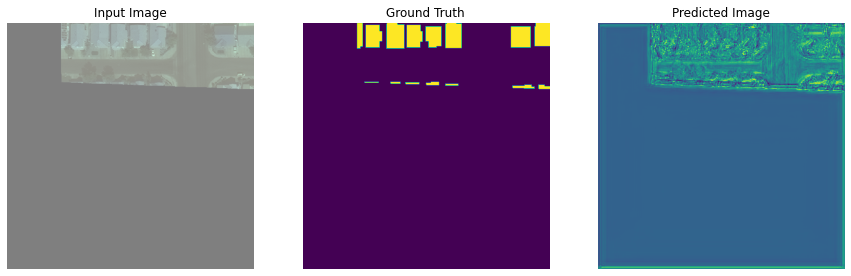

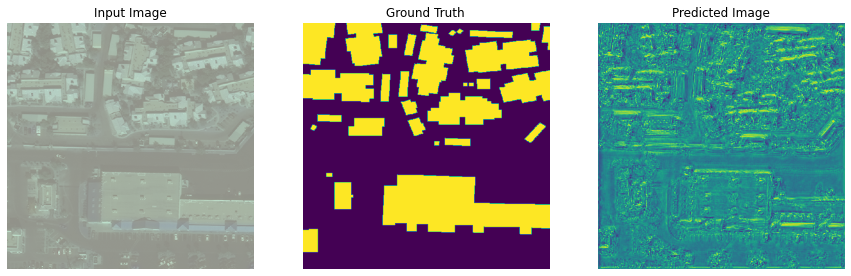

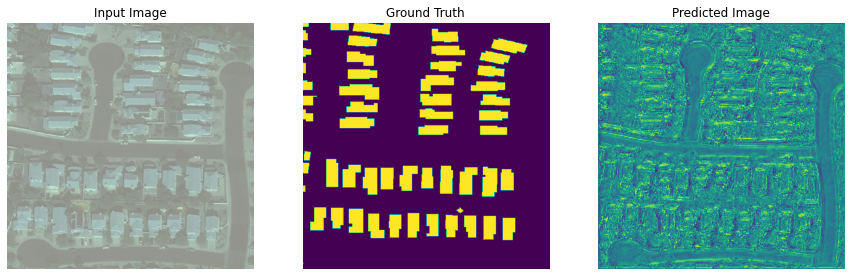

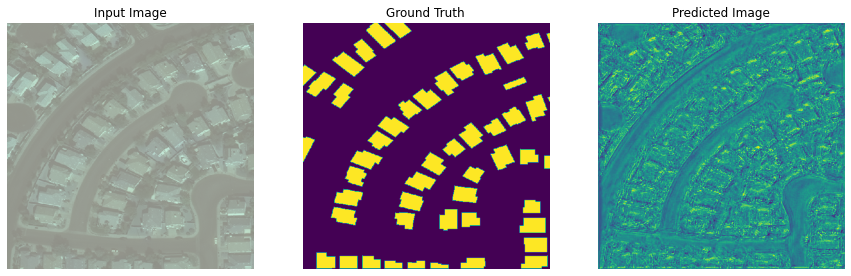

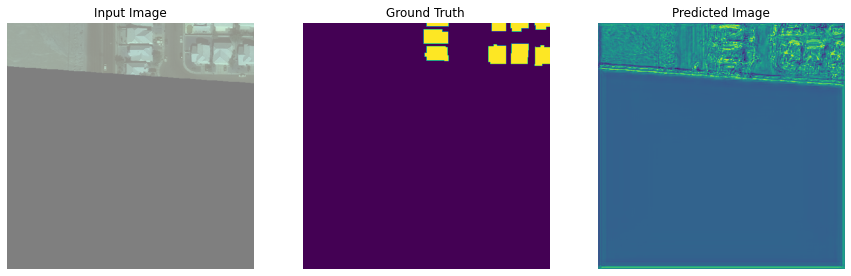

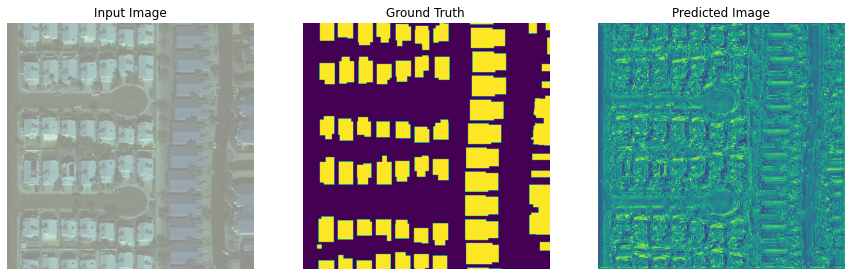

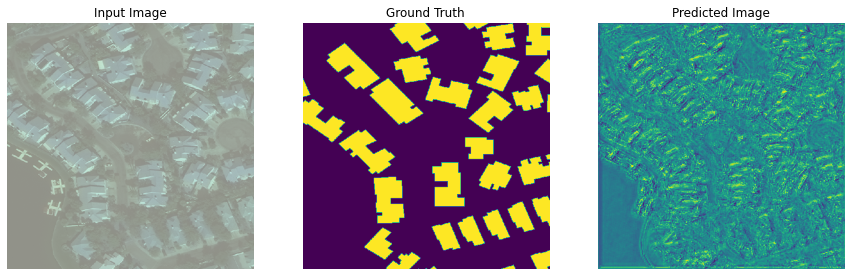

In [36]:
for example_input, example_target in test_dataset.take(7):
    generate_images(generator, example_input, example_target)

## Training

* For each example input generate an output.
* The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
* Next, calculate the generator and the discriminator loss.
* Then, calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
* Then log the losses to TensorBoard.

In [35]:
EPOCHS = 40

metrics = tf.keras.metrics.MeanIoU(num_classes=2)


In [36]:
import datetime
log_dir="/glade/scratch/hgamarro/Deep_learning/Final_Project/models/scratch/NCAR/logs_2/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [37]:
# Added my own vgg16 unet for generator mods and used checkpoint to continue training v2

checkpoint_dir = '/glade/scratch/hgamarro/Deep_learning/Final_Project/models/scratch/NCAR/logs_2/training_checkpoints_mods_V2'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [72]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        #print(gen_output.shape)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

The actual training loop:

* Iterates over the number of epochs.
* On each epoch it clears the display, and runs `generate_images` to show it's progress.
* On each epoch it iterates over the training dataset, printing a '.' for each example.
* It saves a checkpoint every 20 epochs.

In [73]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()

        display.clear_output(wait=True)

        for example_input, example_target in test_ds.take(5):
            generate_images(generator, example_input, example_target)
        print("Epoch: ", epoch)

        # Train
        for n, (input_image, target) in train_ds.enumerate():
            print('.' + str(n.numpy()), end='')
            if (n+1) % 100 == 0:
                print()
            train_step(input_image, target, epoch)
        print()
        
        
#         print("Calculating Validation")
#         sum_iou = []
#         for example_input, example_target in test_ds.take(len(test_ds)):
#             prediction = generator(example_input, training=False )

#             metrics.update_state(example_target,prediction , sample_weight=None)
#             sum_iou.append(metrics.result().numpy())
#             metrics.reset_states()

#         iou_average = np.average(sum_iou)
        
#         with summary_writer.as_default():
#             tf.summary.scalar('iou_score', iou_average, step=epoch)

    # saving (checkpoint) the model every 3 epochs
        if (epoch + 1) % 1 == 0:
            print("scaving checkpoint")
            checkpoint.save(file_prefix=checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
    checkpoint.save(file_prefix=checkpoint_prefix)

This training loop saves logs you can easily view in TensorBoard to monitor the training progress. Working locally you would launch a separate tensorboard process. In a notebook, if you want to monitor with TensorBoard it's easiest to launch the viewer before starting the training.

To launch the viewer paste the following into a code-cell:

Now run the training loop:

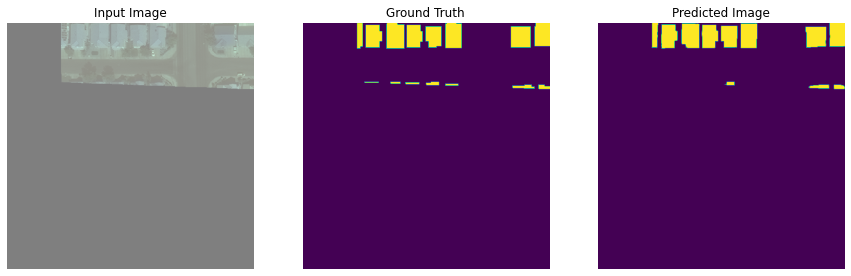

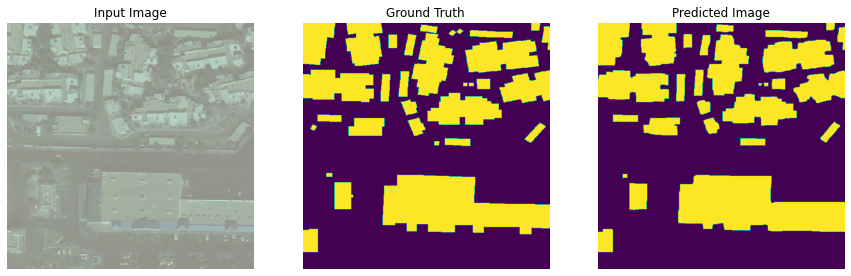

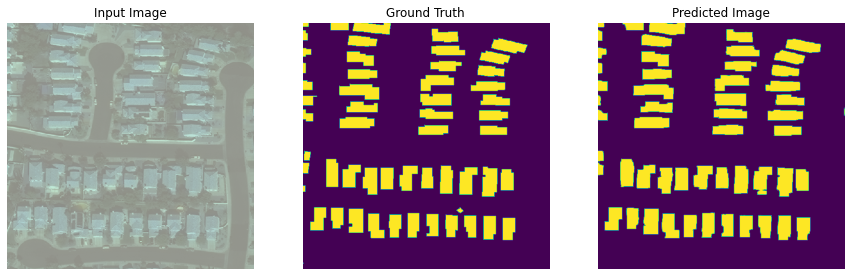

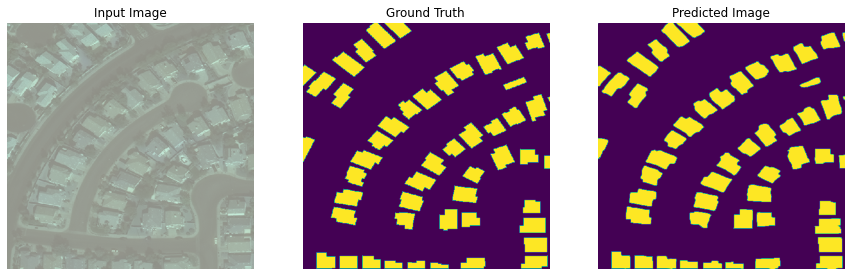

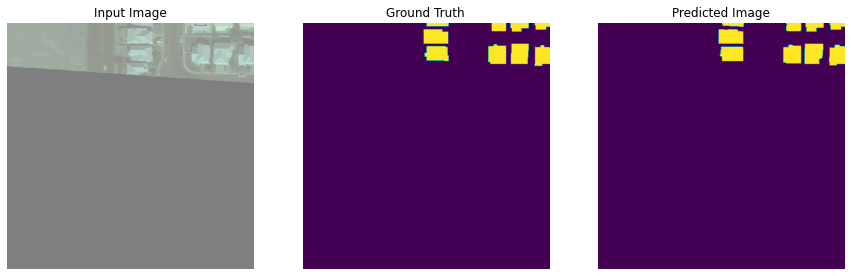

Epoch:  39
.0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.53.54.55.56.57.58.59.60.61.62.63.64.65.66.67.68.69.70.71
scaving checkpoint
Time taken for epoch 40 is 135.33602857589722 sec



In [74]:
fit(train_dataset, EPOCHS, test_dataset)

Interpreting the logs from a GAN is more subtle than a simple classification or regression model. Things to look for::

* Check that neither model has "won". If either the `gen_gan_loss` or the `disc_loss` gets very low it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
* The value `log(2) = 0.69` is a good reference point for these losses, as it indicates a perplexity of 2: That the discriminator is on average equally uncertain about the two options.
* For the `disc_loss` a value below `0.69` means the discriminator is doing better than random, on the combined set of real+generated images.
* For the `gen_gan_loss` a value below `0.69` means the generator is doing better than random at fooling the descriminator.
* As training progresses the `gen_l1_loss` should go down.

## Restore the latest checkpoint and test

In [75]:
!ls {checkpoint_dir}

checkpoint		     ckpt-29.index
ckpt-10.data-00000-of-00001  ckpt-2.data-00000-of-00001
ckpt-10.index		     ckpt-2.index
ckpt-11.data-00000-of-00001  ckpt-30.data-00000-of-00001
ckpt-11.index		     ckpt-30.index
ckpt-12.data-00000-of-00001  ckpt-31.data-00000-of-00001
ckpt-12.index		     ckpt-31.index
ckpt-13.data-00000-of-00001  ckpt-32.data-00000-of-00001
ckpt-13.index		     ckpt-32.index
ckpt-14.data-00000-of-00001  ckpt-33.data-00000-of-00001
ckpt-14.index		     ckpt-33.index
ckpt-15.data-00000-of-00001  ckpt-34.data-00000-of-00001
ckpt-15.index		     ckpt-34.index
ckpt-16.data-00000-of-00001  ckpt-35.data-00000-of-00001
ckpt-16.index		     ckpt-35.index
ckpt-17.data-00000-of-00001  ckpt-36.data-00000-of-00001
ckpt-17.index		     ckpt-36.index
ckpt-18.data-00000-of-00001  ckpt-37.data-00000-of-00001
ckpt-18.index		     ckpt-37.index
ckpt-19.data-00000-of-00001  ckpt-38.data-00000-of-00001
ckpt-19.index		     ckpt-38.index
ckpt-1.data-00000-of-00001   ckpt-39.data-00000-of-00001
ckpt

In [76]:
checkpoint_dir

'/glade/scratch/hgamarro/Deep_learning/Final_Project/models/scratch/NCAR/logs_2/training_checkpoints_mods_V2'

In [38]:
def my_tf_round(x, decimals = 0):
    multiplier = tf.constant(10**decimals, dtype=x.dtype)
    return tf.nn.relu(tf.round(x * multiplier) / multiplier)

In [39]:
# restoring the latest checkpoint in checkpoint_dir

final_checkpoint_dir = '/glade/scratch/hgamarro/Deep_learning/Final_Project/models/scratch/NCAR/logs_2/training_checkpoints_mods_V2/ckpt-23'
# final_checkpoint_dir = '/glade/scratch/hgamarro/Deep_learning/Final_Project/models/scratch/NCAR/logs_2/training_checkpoints/ckpt-14'

checkpoint.restore(final_checkpoint_dir)

In [89]:
metrics = tf.keras.metrics.MeanIoU(num_classes=2)
metrics_pre = tf.keras.metrics.Recall()
metrics_rec = tf.keras.metrics.Precision()


print("Calculating Validation")
sum_iou = []
sum_pre = []
sum_rec = []

for example_input, example_target in test_dataset.take(len(test_dataset)):
    prediction = generator(example_input, training=False )

    metrics.update_state(example_target,my_tf_round(prediction) , sample_weight=None)
    sum_iou.append(metrics.result().numpy())
    metrics.reset_states()
    
    
    metrics_pre.update_state(example_target,my_tf_round(prediction), sample_weight=None)
    sum_pre.append(metrics_pre.result().numpy())
    metrics_pre.reset_states()
    
    
    metrics_rec.update_state(example_target,my_tf_round(prediction), sample_weight=None)
    sum_rec.append(metrics_rec.result().numpy())
    metrics_rec.reset_states()

iou_average = np.average(sum_iou)
rec_average = np.average(sum_rec)
pre_average = np.average(sum_pre)

print(iou_average)
print(rec_average)
print(pre_average)
f1_score = rec_average * pre_average *2 / (rec_average + pre_average)
print(f1_score)

Calculating Validation
0.9426072
0.95044446
0.9543775
0.952406951108481


## Generate using test dataset

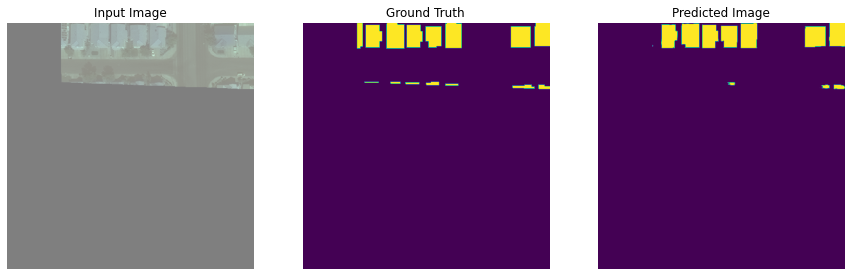

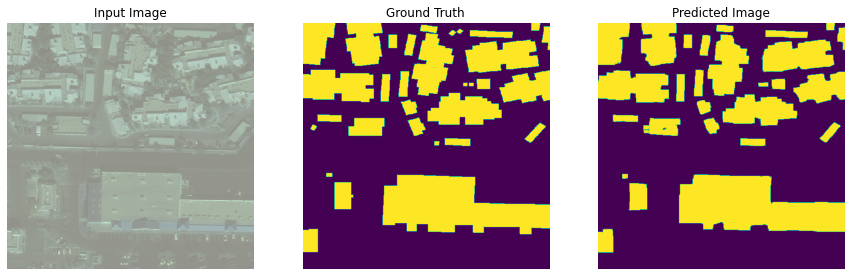

In [40]:
# Run the trained model on a few examples from the test dataset
for inp2, tar2 in test_dataset.take(2):
  generate_images(generator, inp2, tar2)

In [41]:
generator_ex = generator(inp2,training=False)
disc_real_output_ex = discriminator([inp2, tar2], training=False)
disc_generated_output_ex = discriminator([inp2, generator_ex], training=False)

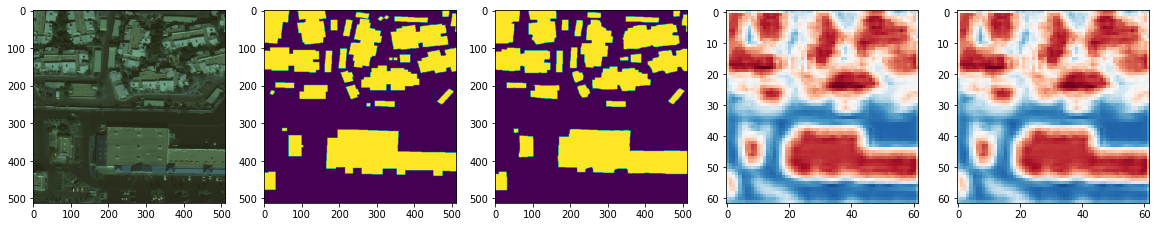

In [43]:
idxx = 0
fig, axes = plt.subplots(1, 5, figsize=(20, 9))

# fig.subplots_adjust(hspace=0.1)


axes[0].imshow(inp2[idxx])

axes[1].imshow(tar2[idxx],vmin=0, vmax=1)
axes[2].imshow(generator_ex[idxx],vmin=0, vmax=1)
axes[3].imshow(disc_generated_output_ex[idxx],vmin=-2, vmax=3,  cmap='RdBu_r')
axes[4].imshow(disc_generated_output_ex[idxx],vmin=-2, vmax=3,  cmap='RdBu_r')

# # axes[0].axis('off')
# # axes[1].axis('off')
# # axes[2].axis('off')
# # axes[3].axis('off')
# # axes[4].axis('off')




#     axes[0, a].imshow( image)
#     axes[0, a].imshow( image)
#     axes[0, a].imshow( image)
#     axes[0, a].imshow( image)
plt.savefig('../random/img2d.png', bbox_inches='tight')

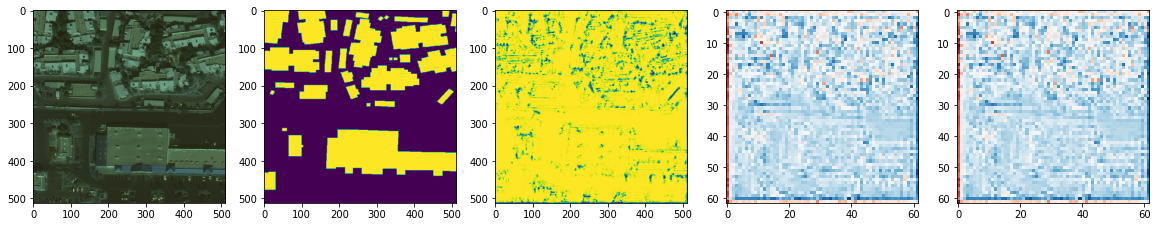

In [165]:
fig, axes = plt.subplots(1, 5, figsize=(20, 9))

# fig.subplots_adjust(hspace=0.1)


axes[0].imshow(inp2[idxx])

axes[1].imshow(tar2[idxx],vmin=0, vmax=1)
axes[2].imshow(generator_ex[idxx],vmin=0, vmax=1)
axes[3].imshow(disc_generated_output_ex[idxx],  cmap='RdBu_r')
axes[4].imshow(disc_generated_output_ex[idxx],  cmap='RdBu_r')

# # axes[0].axis('off')
# # axes[1].axis('off')
# # axes[2].axis('off')
# # axes[3].axis('off')
# # axes[4].axis('off')




#     axes[0, a].imshow( image)
#     axes[0, a].imshow( image)
#     axes[0, a].imshow( image)
#     axes[0, a].imshow( image)

plt.savefig('../random/img2c.png', bbox_inches='tight')

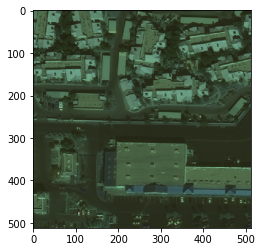

In [121]:
plt.imshow(inp2[idxx])

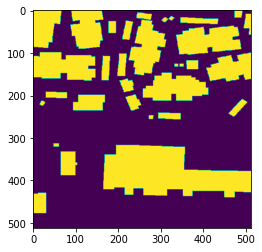

In [110]:
idxx = [0]

plt.imshow(tar2[idxx],vmin=0, vmax=1)


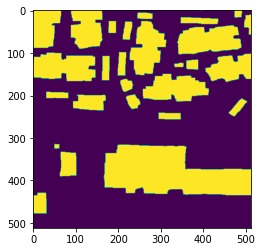

In [111]:
plt.imshow(generator_ex[idxx],vmin=0, vmax=1)

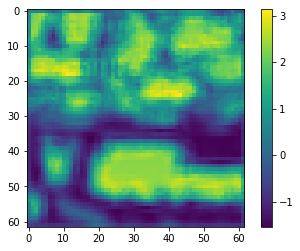

In [112]:
plt.imshow(disc_real_output_ex[idxx])
plt.colorbar()

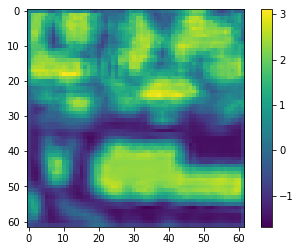

In [113]:
plt.imshow(disc_generated_output_ex[idxx])
plt.colorbar()

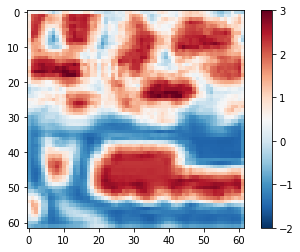

In [118]:
aa = -2
bb=3
plt.imshow(disc_real_output_ex[idxx],vmin=aa, vmax=bb,  cmap='RdBu_r')
plt.colorbar()

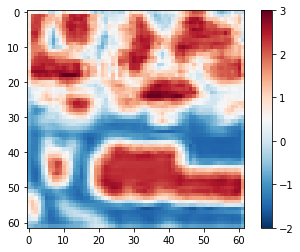

In [119]:
plt.imshow(disc_generated_output_ex[idxx],vmin=aa, vmax=bb,  cmap='RdBu_r')
plt.colorbar()

In [120]:
gen_total_loss_ex, gen_gan_loss_ex, gen_l1_loss_ex = generator_loss(disc_generated_output_ex, generator_ex, tar2)
print(gen_total_loss_ex)
print(gen_gan_loss_ex)
print(gen_l1_loss_ex)


disc_loss_ex = discriminator_loss(disc_real_output_ex, disc_generated_output_ex)
print(disc_loss_ex)

tf.Tensor(3.2870169, shape=(), dtype=float32)
tf.Tensor(0.65528053, shape=(), dtype=float32)
tf.Tensor(0.026317364, shape=(), dtype=float32)
tf.Tensor(1.6891794, shape=(), dtype=float32)


In [48]:
generator_ex = generator(inp2.numpy(),training=False)

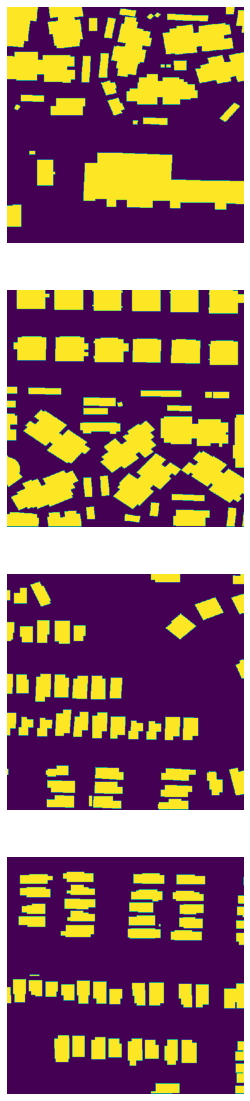

In [61]:
idxx = 0
fig, axes = plt.subplots(4, 1, figsize=(20, 20))

# fig.subplots_adjust(hspace=0.1)


axes[0].imshow(tar2[0],vmin=0, vmax=1)
axes[1].imshow(tar2[1],vmin=0, vmax=1)
axes[2].imshow(tar2[2],vmin=0, vmax=1)
axes[3].imshow(tar2[3],vmin=0, vmax=1)

axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[3].axis('off')

plt.savefig('../random/targetimg.png', bbox_inches='tight')


In [ ]:
idxx = 0
fig, axes = plt.subplots(4, 1, figsize=(20, 20))

# fig.subplots_adjust(hspace=0.1)


axes[0].imshow(inp2[0])
axes[1].imshow(inp2[1])
axes[2].imshow(inp2[2])
axes[3].imshow(inp2[3])

axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[3].axis('off')

plt.savefig('../random/inputimg.png', bbox_inches='tight')

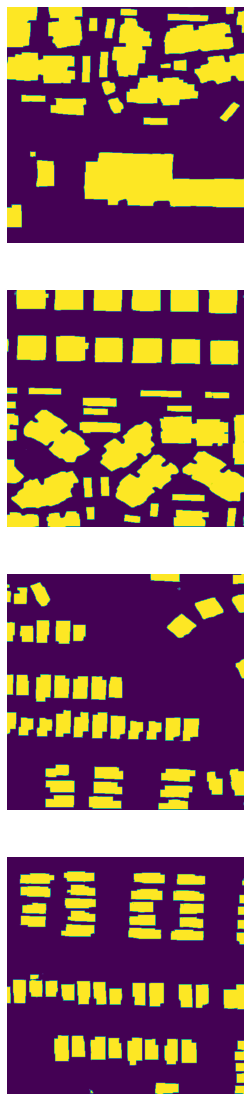

In [56]:
idxx = 0
fig, axes = plt.subplots(4, 1, figsize=(20, 20))

# fig.subplots_adjust(hspace=0.1)


axes[0].imshow(generator_ex[0],vmin=0, vmax=1)
axes[1].imshow(generator_ex[1],vmin=0, vmax=1)
axes[2].imshow(generator_ex[2],vmin=0, vmax=1)
axes[3].imshow(generator_ex[3],vmin=0, vmax=1)

axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[3].axis('off')

plt.savefig('../random/pix2pixv2.png', bbox_inches='tight')
